<a href="https://colab.research.google.com/github/pinballsurgeon/sweeping_analysis/blob/main/emergence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## installs

In [1]:
!pip install pytrends
!pip install joypy

# install openai
!pip install openai

## imports

In [2]:
import numpy
import pandas 

from pytrends.request import TrendReq
from pytrends         import dailydata
import pytrends
from operator         import index

import joypy
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn 

import openai

# supply openai api key via file 
openai.api_key = open('openai_key').read()


## seed config

In [3]:
# connection strenth minimum boost, base on standard deviation
std_factor = .6


# seed topics
topics = ['flipflops', 'pumpkin', 'turkey', 'baseball', 'basketball', 'football'
        , 'new years', 'nascar', 'salad', 'soup', 'stuffing'
        , 'kite', 'ice cream', 'hotdog', 'rocket', 'fireworks', 'pizza', 'bbq', 'parade']



In [4]:
# for a given list of topics, return dataframe of interests from pytrend
def get_trend_frame(topics, years):

  # initialize return frame
  df_total = pandas.DataFrame()

  # for each provided 
  for topic in topics:

    # pytrend request
    pytrend = TrendReq()
    pytrend.build_payload(kw_list=[topic]
                         ,timeframe=( 'today %s-y' % (years)))
    
    # load trend request
    df = pytrend.interest_over_time()

    # add column for new topic
    df_total[topic] = df[topic]

  # drop nans
  df_total = df_total.dropna()

  # return standard frame
  return df_total

In [19]:
def stack_nodes_vertically(df_features):

  # initialize buffers resources
  df_stk=pandas.DataFrame()
  globalst=[]

  # for each feature
  for col in df_features:                      # topic

      # for each time interval
      for val in df_features.index.weekofyear: # weeknum

          # time sensitive
          fs_val = df_features[col][val]       # full spectrum
          
          # iterate through each instance of max bin occurence, determining number of weeks written
          for x in range(0,int(abs(fs_val) * 100)):
          
              # build buffer list
              lst = [val, val, col]
              globalst.append(lst)

  # materialize vertically flattened
  df_flat = pandas.DataFrame(globalst
                            ,columns=['WeekNum'
                            ,'WeekNum_Rct'
                            ,'Flower_Tot'])
  
  return df_flat

In [23]:
def build_node_labels(df_flat):
  
  # get all distinct nodes
  df_stats = df_flat.groupby('Flower_Tot').agg(['mean', 'count']).reset_index()

  # rename columns to node labels
  df_stats.columns = [' '.join(col).strip() for col in df_stats.columns.values]

  # sort by average time interval
  df_stats = df_stats.sort_values(by='WeekNum mean',ascending=True)

  # include average into node label
  df_stats['Name'] = ( ( df_stats['WeekNum mean'] * 100) + 1000).astype('int').astype('str') + ' '+ df_stats['Flower_Tot']

  # update flattened node space with averaged names
  for index, row in df_stats.iterrows():
      df_flat['Flower_Tot'] = df_flat['Flower_Tot'].replace(row['Flower_Tot'], row['Name'])

  return df_flat

In [24]:
# request features
df_features = get_trend_frame(topics, '5')[topics]

# normalize feature space
df_features=(df_features-df_features.mean())/df_features.std()

# flatten feature space vertically
df_flat = stack_nodes_vertically(df_features)

# build node labels
df_flat = build_node_labels(df_flat)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  # This is added back by InteractiveShellApp.init_path()


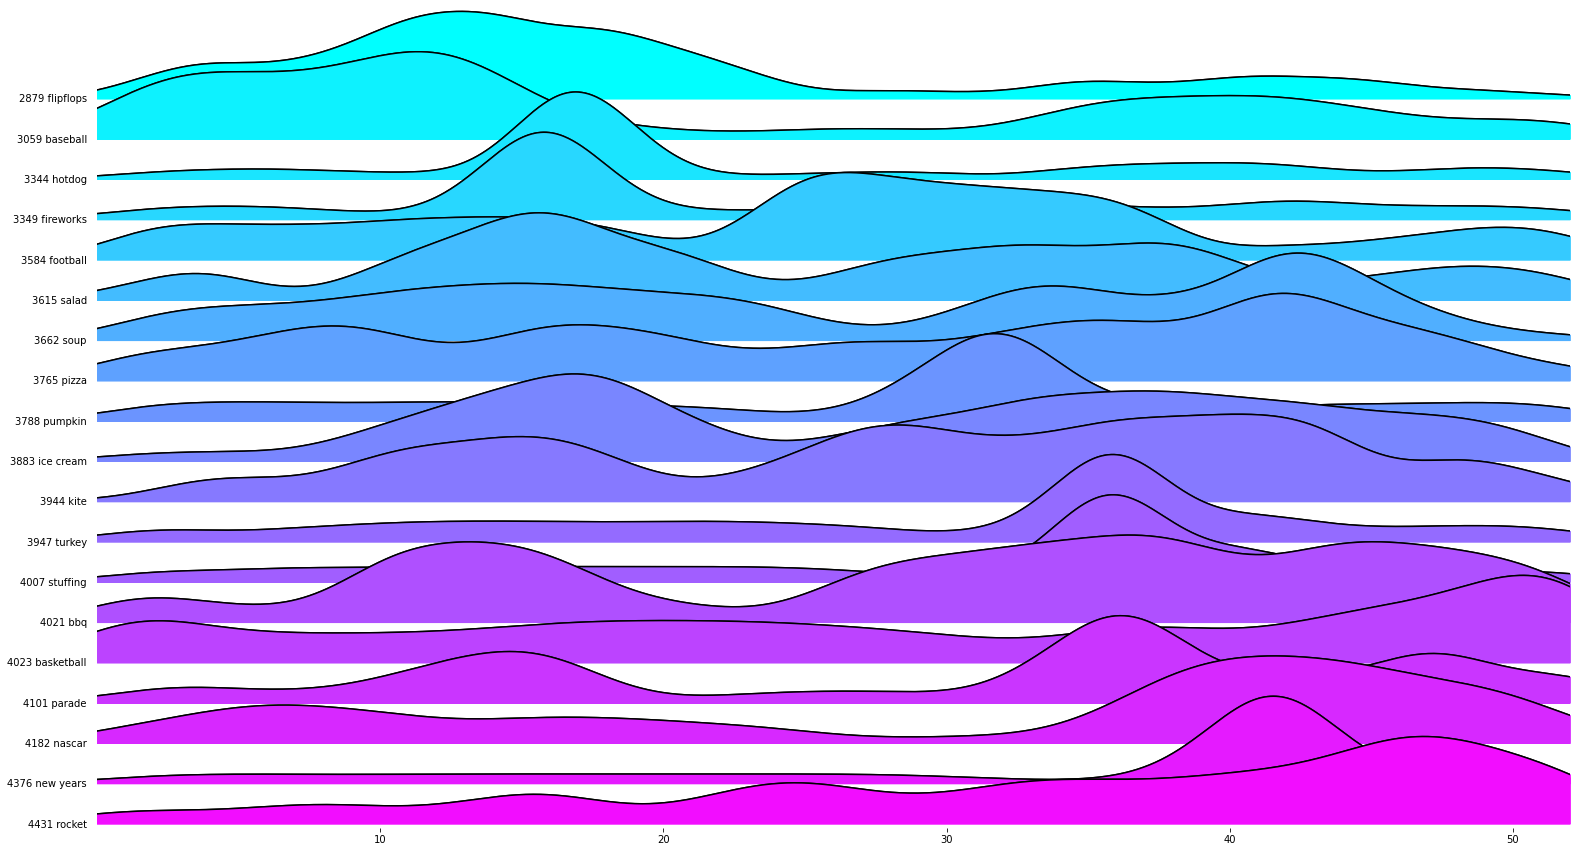

In [8]:
fig, axes = joypy.joyplot(df_flat
                          , column=['WeekNum', 'WeekNum_Rct']
                          , by='Flower_Tot'
                          , overlap=1.2
                          , fill=True
                          , figsize=(22,12)
                          , x_range = [0,52]
                          , colormap=cm.cool                         
                          , ylim='own'
                         )

plt.savefig('frank_jj.png')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f11454abd90>]],
      dtype=object)

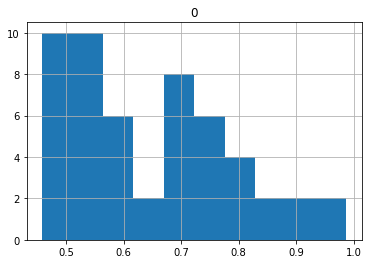

In [10]:

c = df_features.corr().abs()

s = c.unstack()
so = s.sort_values(kind="quicksort")

# remove low connections
min_connection_strength = so.mean() + ( std_factor * so.std() )
min_connection_cutoff = len(so) - len(so[so > min_connection_strength])


# turn to frame
df_slice = so[min_connection_cutoff:-len(topics)].to_frame()
df_slice.hist()

In [11]:
#len(so[so>5])

#so.mean()
#so.max()
#so.std
#so.shape
#df_slice
#len(so)
#seaborn.pairplot(df_slice,diag_kind = 'kde',kind = 'scatter',palette = 'husl')

In [12]:
df_slice.reset_index(inplace=True)

In [13]:
df_slice.columns = ['source','target','weight']

node degree clustering
hotdog 4 0.5
bbq 7 0.47619047619047616
salad 6 0.6
football 2 0
ice cream 8 0.39285714285714285
basketball 2 1.0
pizza 2 1.0
baseball 3 1.0
stuffing 2 1.0
parade 2 1.0
pumpkin 1 0
turkey 2 1.0
soup 5 0.8
fireworks 1 0
flipflops 5 0.8
#/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-318d16f8-e3ef-4c0d-a2a1-dfe801f6e1c3.json
# GMT Mon Mar  7 03:07:26 2022
# 
hotdog bbq salad ice cream fireworks
bbq pizza basketball flipflops soup salad ice cream
salad pizza soup flipflops ice cream
football ice cream pumpkin
ice cream basketball baseball flipflops soup
basketball
pizza
baseball flipflops soup
stuffing parade turkey
parade turkey
pumpkin
turkey
soup flipflops
fireworks
flipflops


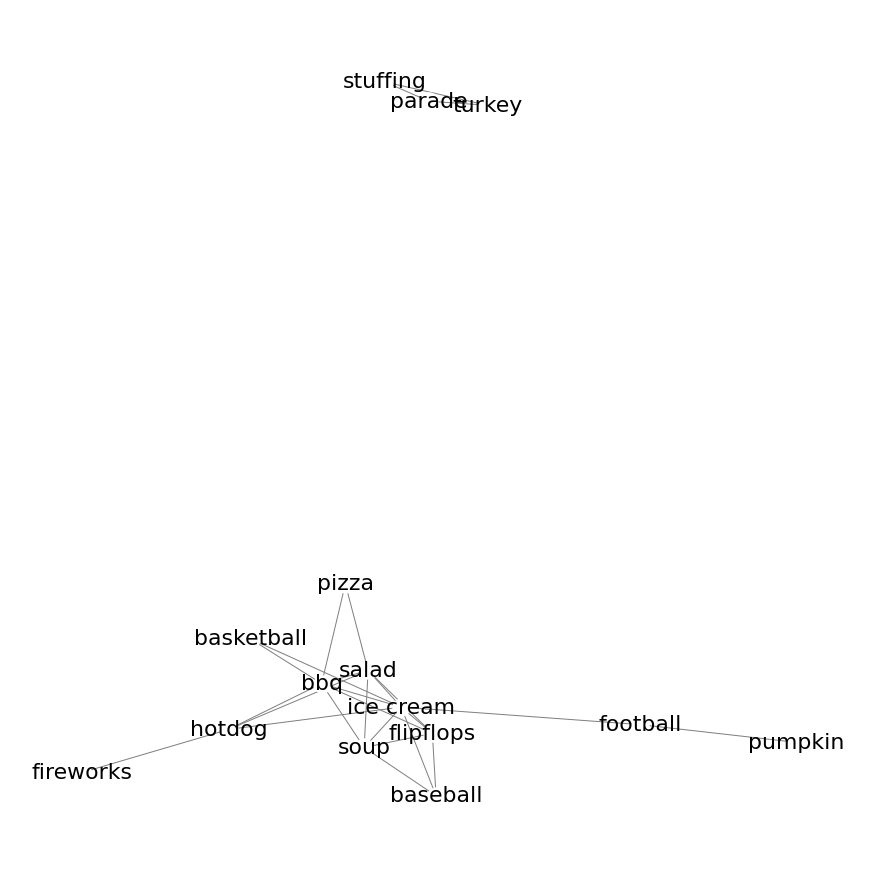

In [14]:
from networkx.algorithms.bipartite.basic import color
from networkx import *
import networkx as nx
import sys

n=10 # 10 nodes
m=20 # 20 edges

#G=gnm_random_graph(n,m)
#G=nx.from_pandas_dataframe(df_slice, 0, 'b', ['weight', 'cost'])
#G = nx.from_pandas_edgelist(df_slice, 'source', 'target', ['weight', 'cost'])
G = nx.from_pandas_edgelist(df_slice, 'source', 'target', ['weight'])


# some properties
print("node degree clustering")
for v in nodes(G):
    print(v,degree(G,v),clustering(G,v))

# print the adjacency list to terminal 
write_adjlist(G,sys.stdout)

plt.figure(3,figsize=(12,12)) 
draw(G
     ,with_labels=True
     ,edge_color='gray'
     ,node_color='white'
     ,font_size=22)


In [15]:
#df_slice.columns(["l","weight", "cost"])
#G["football"]["baseball"]["weight"]


KeyError: ignored

In [ ]:
# list nodes
G.nodes.items()

# edges
G.number_of_edges()

# print neighbors
for v in G.neighbors('rocket'):
  print(v)

In [ ]:
# send openai question, receive response
def get_response(question):
  response = openai.Completion.create(
    engine="text-davinci-001",
    prompt=question,
    temperature=.01,
    max_tokens=250,
    top_p=1,
    frequency_penalty=50,
    presence_penalty=0
  )

  # process response
  response_choices = response["choices"]
  response_choice_text = response_choices[0]["text"]
  ''.join(e for e in response_choice_text if e.isalnum())
  response = response_choices[0]["text"].strip('\n')

  return response

In [ ]:
responses = []


# retrieve 
retrieval = get_response('List similiar seasonal occurying concepts to baseball besides basketball and football and hockey and soccer')
responses.append(retrieval)

In [ ]:
responses